In [49]:
%load_ext autoreload
%autoreload 2

from Openseas_Methods import pull_sales_data,make_graph,make_nft_graph,pull_nft_stats,edge_counts_to_percent
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygraphviz
import random
from pymongo import MongoClient
from tqdm import tqdm
import pandas as pd
import gc
from itertools import combinations
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Finds all transaction hashes for sales

client = MongoClient()
db =client.NFTDB
sales_data = db.salesCollection
transfers = db.transfersCollection
WallettoNFT = db.addresstoNFT

In [3]:
record = WallettoNFT.find({})
df = pd.DataFrame.from_records(record)
df

,_id,address,timestamp,NFTs,NFTandToken
0,650219e70b1e4a567a783a18,0x7d5dfe0d2e2c1fff316e7cd9ba52dc85d8ff70a6,2023-09-13 20:21:59.510,"[opensea-paymentassets, azukielementals, unisw...",NaN
1,650219e80b1e4a567a783a19,0x7d5e397f078adaf32562f13c2b9dda66d7fb40e7,2023-09-13 20:22:00.124,"[boba-inu-1, opensea-paymentassets, the-robber...",NaN
2,650219ec0b1e4a567a783a1a,0x7d5e5f38279d11be376a8f97c654036c3e8d3a4c,2023-09-13 20:22:04.117,"[opensea-paymentassets, hapebadge, tinypaws, s...",NaN
3,650219ec0b1e4a567a783a1b,0x7d5e74d1fbf9ebe1f8f582114dc68f8229cf6801,2023-09-13 20:22:04.630,"[maxwellinked, zafgodop, opensea-paymentassets...",NaN
4,650219ed0b1e4a567a783a1c,0x7d5f4c5786ad0a84fc328870b914db011bc50e1f,2023-09-13 20:22:05.545,"[journey-dreamlab, dourfits, ghost-boy-lives, ...",NaN
...,...,...,...,...,...
240119,651a04533d8fce344df96d83,0x7f72bec39b3894ec1fd0604ff2c221f8221f3f7d,2023-10-01 23:44:19.591,[rainbow-zorb],"[rainbow-zorb, 92320]"
240120,651a04563d8fce344df96d84,0x7f72e3106478626ee8b2e16a8ee9af26f5b55eb4,2023-10-01 23:44:22.050,"[metaangelsnft, remarkablewomennft, ens, globa...","[nftnowpodcast, 1, new-world-order-by-iwwon, 8..."
240121,651a04563d8fce344df96d85,0x7f7835dfe1f050f48597380551d5d2ef792d50bf,2023-10-01 23:44:22.663,"[castprotocol, ens, many-fold, argus-genesis, ...","[castprotocol, 6114747947817910278990138492503..."
240122,651a04573d8fce344df96d86,0x7f79d20d51d09be0d0b519982fa32c04abf8de2e,2023-10-01 23:44:23.073,"[wonderpals, veefriends-series-2, bokinftoffic...","[froggyfriendsnft, 3881, froggyfriendsnft, 361..."


In [4]:
for comb in combinations(df.NFTs.iloc[0], r=2):
    print(tuple(sorted(list(comb))))
    # print(tuple(list(comb).sort()))

('azukielementals', 'opensea-paymentassets')
('opensea-paymentassets', 'uniswap-v3-positions')
('opensea-paymentassets', 'sproto-gremlins')
('azukielementals', 'uniswap-v3-positions')
('azukielementals', 'sproto-gremlins')
('sproto-gremlins', 'uniswap-v3-positions')


In [47]:
# db.nftCombinations.delete_many({})
# del all_combos
# del requests
# gc.collect()

In [40]:
len(all_combos)
# min(all_combos, key=all_combos.get)
# all_combos["('boba-inu-1', 'zeitgeist-nft')"]

20206471

In [48]:
from pymongo import UpdateOne
all_combos = defaultdict(lambda:0)
batch = len(df.NFTs) // 20
i = 0
for nft in tqdm(df.NFTs, position=0, leave=True):
    for comb in combinations(nft, r=2):
        if 'opensea-paymentassets' in comb or 'ens' in comb:
            continue
        else:
            sorted_comb = tuple(sorted(list(comb)))
            all_combos[str(sorted_comb)]+=1
    if (i % batch == 0 and i > 0) or i == len(df.NFTs) - 1:
        requests = []
        combos_filtered = {key:val for key, val in all_combos.items() if val >1}
        for key in tqdm(combos_filtered, desc='Generating Requests', position=0, leave=True):
            # db.nftCombinations.update_one({'_id': key}, { '$inc': { 'value': all_combos[key]}}, upsert=True)
            requests.append(UpdateOne({'_id': key}, { '$inc': { 'value': all_combos[key]}}, upsert=True))
        db.nftCombinations.bulk_write(requests)
        del requests
        print('Finished Writing')
        all_combos = defaultdict(lambda:0)
    i += 1

  5%|███▌                                                                   | 12035/240124 [03:31<46:28:42,  1.36it/s]

Finished Writing


 10%|███████                                                                | 24053/240124 [06:59<30:40:26,  1.96it/s]

Finished Writing


 15%|██████████▋                                                            | 36127/240124 [11:26<33:43:32,  1.68it/s]

Finished Writing


 20%|██████████████▏                                                        | 48025/240124 [14:29<22:27:41,  2.38it/s]

Finished Writing


 25%|█████████████████▊                                                     | 60064/240124 [19:03<54:22:20,  1.09s/it]

Finished Writing


 30%|█████████████████████▎                                                 | 72113/240124 [22:27<36:13:35,  1.29it/s]

Finished Writing


 35%|████████████████████████▉                                              | 84223/240124 [26:19<19:41:25,  2.20it/s]

Finished Writing


 40%|████████████████████████████▍                                          | 96142/240124 [29:48<14:52:26,  2.69it/s]

Finished Writing


 45%|███████████████████████████████▌                                      | 108161/240124 [33:51<21:06:45,  1.74it/s]

Finished Writing


 50%|███████████████████████████████████                                   | 120146/240124 [38:08<16:32:53,  2.01it/s]

Finished Writing


 55%|██████████████████████████████████████▌                               | 132155/240124 [42:31<17:21:36,  1.73it/s]

Finished Writing


 60%|██████████████████████████████████████████▋                            | 144193/240124 [45:41<8:45:18,  3.04it/s]

Finished Writing


 65%|██████████████████████████████████████████████▏                        | 156279/240124 [47:46<3:47:08,  6.15it/s]

Finished Writing


 70%|█████████████████████████████████████████████████                     | 168199/240124 [52:53<16:06:01,  1.24it/s]

Finished Writing


 75%|█████████████████████████████████████████████████████▎                 | 180166/240124 [57:13<9:20:22,  1.78it/s]

Finished Writing


 80%|███████████████████████████████████████████████████████▏             | 192170/240124 [1:00:54<7:42:34,  1.73it/s]

Finished Writing


 85%|██████████████████████████████████████████████████████████▋          | 204213/240124 [1:06:37<7:08:45,  1.40it/s]

Finished Writing


 90%|██████████████████████████████████████████████████████████████▏      | 216262/240124 [1:11:12<3:41:01,  1.80it/s]

Finished Writing


 95%|█████████████████████████████████████████████████████████████████▌   | 228209/240124 [1:16:06<2:03:07,  1.61it/s]

Finished Writing


100%|██████████████████████████████████████████████████████████████████████▉| 240121/240124 [1:20:33<00:02,  1.10it/s]

Finished Writing


Adding to Mongo: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████▉| 240123/240124 [1:20:33<00:00, 49.68it/s]


InvalidOperation: No operations to execute

In [14]:
all_combos = defaultdict(lambda:0)

for nft in tqdm(df.NFTs):
    for comb in combinations(nft, r=2):
        if 'opensea-paymentassets' in comb or 'ens' in comb:
            continue
        else:
            sorted_comb = tuple(sorted(list(comb)))
            all_combos[sorted_comb]+=1

  1%|▊                                                                         | 2674/240124 [00:03<05:49, 680.21it/s]


KeyboardInterrupt: 

In [34]:
with open('combo_dict_50.pkl','wb') as f:
    pickle.dump(combos_50,f)

In [21]:
combos_10.items()

TypeError: 'dict_items' object is not subscriptable

In [33]:
combos_50 = {key:val for key, val in all_combos.items() if val >50}
# print(len(combos_100))
# min(combos_100.items(), key=lambda a: a[1])

In [29]:
with open('combo_dict_50.pkl','rb') as f:
    combos_50 = pickle.load(f)

In [32]:
combos_50[('azukielementals', 'uniswap-v3-positions')]
# combos_50[('uniswap-v3-positions', 'azukielementals')]

84

In [16]:
from collections import defaultdict
slug_to_counts = defaultdict(lambda: 0)
for key,val in combos_50.items():
    if key[0]=='apecoin' or key[1]=='apecoin':
        continue
    else:
        slug_to_counts[key[0]]+= val
        slug_to_counts[key[1]]+=val
top_1000 = dict(sorted(slug_to_counts.items(), key=lambda x: x[1], reverse=True)[:1000])
print(top_1000)

{'base-introduced': 508081, 'fundrop-pass': 437500, 'gemesis': 391853, 'usd-c': 249557, 'rarible': 167664, 'parallelalpha': 144474, 'shanghai-capella': 134026, 'rainbow-zorb': 126618, 'the-sandbox-assets': 105804, 'merge-regenesis': 102129, 'fundrop-1-mint-machine-by-numo': 100684, 'unidentified-contract-kg9mf80eue': 99138, 'uniswap-v3-positions': 93179, 'fundrop-stickers': 88682, 'zerion-dna-onepointo': 87400, 'the-escher-edition-1': 87363, 'eigenworlds': 85363, 'nametag-general': 83928, 'known-origin': 80376, 'mirror-community-nfts': 79058, 'argus-genesis': 76558, 'decagon-by-golid-and-deca': 74757, 'notablepepes': 73398, 'stand-with-crypto': 72710, 'friendship-bracelets-by-alexis-andre': 71093, 'otherdeed-expanded': 70161, 'otherside-vessels': 66217, 'to-ethereum-with-love': 63306, 'augminted-labs-scientists': 59480, 'zenacademy-student-ids': 58880, 'dai-stablecoin': 55984, 'octagon-by-deca': 55819, 'dead-ringers-edition-by-dmitri-cherniak': 53095, 'censored-pak-assange': 50639, 'eg

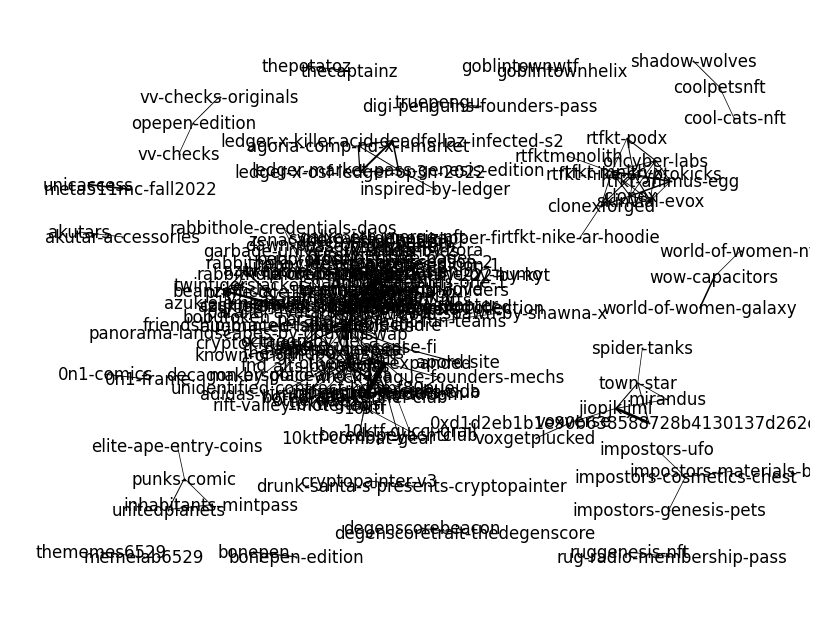

In [96]:

G = make_nft_graph(list(combos_500.items()),weight_div=1000,skip_list=['ens','base-introduced','fundrop-pass','gemesis'])
plt.figure(figsize=(8,6))
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos =  nx.nx_agraph.graphviz_layout(G, prog="neato")
# draw graph
nx.draw(
    G, pos,
    # nodes
    node_size=2, node_color='k', linewidths=0, with_labels = True,# (linewidths of node markers)
    # edges
    edgelist = edges,
    width=weights

)

# draw disconnected DSPs in red
# nx.draw_networkx_nodes(
#     G, pos, nodelist=disconnected,
#     node_size=2, node_color='r', linewidths=0, 
# )
# nx.draw_networkx_labels(
#     G, pos,
#     labels={dsp: dsp for dsp in disconnected}, font_size=3, verticalalignment='bottom', font_color='r'
# )
plt.show()

(0.729, 0.537, 0.636, 1.162, 0.596, 1.92, 0.726, 0.661, 0.894, 1.193, 0.726, 0.719, 0.561, 0.758, 0.728, 0.696, 0.503, 0.56, 1.383, 1.126, 0.516, 1.685, 0.933, 1.301, 1.75, 0.901, 0.67, 0.616, 0.552, 1.272, 0.51, 0.708, 0.736, 0.585, 0.822, 0.511, 0.826, 0.808, 0.625, 1.329, 0.73, 0.607, 0.519, 0.957, 0.562, 0.581, 0.528, 0.975, 0.622, 0.638, 0.562, 0.515, 0.507, 0.545, 0.73, 0.558, 0.516, 0.514, 0.681, 0.523, 0.529, 0.843, 0.682, 0.574, 0.707, 0.811, 0.885, 0.934, 0.915, 0.559, 0.662, 0.589, 0.524, 0.766, 0.821, 0.789, 1.694, 0.748, 0.773, 0.519, 1.66, 0.848, 0.657, 0.567, 1.579, 0.823, 0.921, 0.782, 0.809, 1.622, 0.979, 0.695, 0.57, 0.772, 0.581, 0.559, 0.631, 0.521, 0.583, 0.53, 0.734, 0.695, 0.626, 0.807, 0.537, 0.531, 0.576, 0.811, 0.59, 0.736, 0.688, 0.722, 0.55, 0.544, 0.62, 0.558, 0.577, 0.554, 0.503, 1.162, 0.571, 0.861, 0.556, 1.101, 0.627, 0.9, 0.52, 0.757, 0.616, 0.516, 0.637, 0.643, 0.517, 0.561, 1.156, 0.515, 0.505, 0.884, 0.573, 0.524, 0.86, 0.561, 0.726, 0.519, 0.719, 0

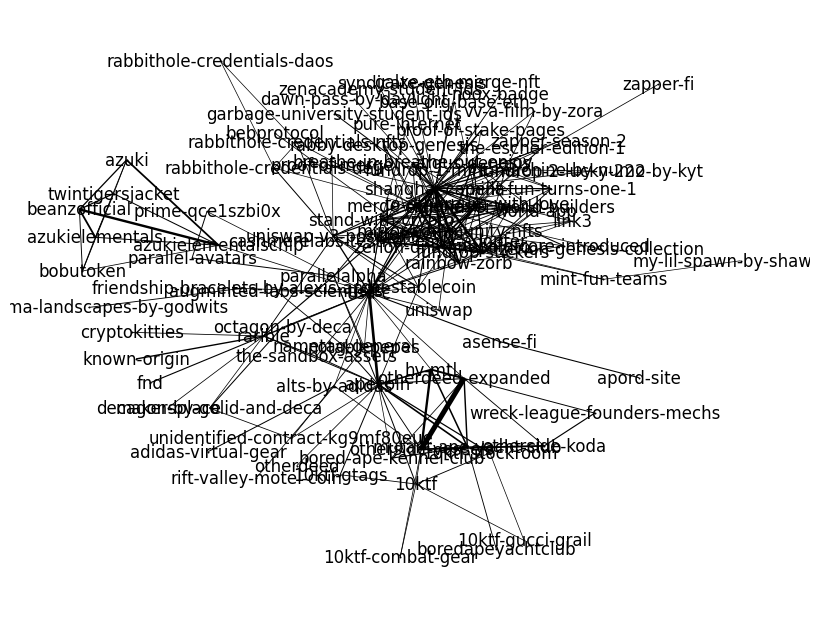

In [97]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
plt.figure(figsize=(8,6))
edges,weights = zip(*nx.get_edge_attributes(G0,'weight').items())
print(weights)
pos =  nx.nx_agraph.graphviz_layout(G0, prog="neato")
print(G0.nodes())
# draw graph
nx.draw(
    G0, pos,
    # nodes
    node_size=2, node_color='k', linewidths=0, with_labels = True,# (linewidths of node markers)
    # edges
    edgelist = edges,
    width=weights

)

In [98]:
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(G0)
net.show('test.html')

test.html


In [106]:
nft_to_stat = set(list(sum(combos_50.keys(), ())))


In [16]:
print(len(list(nft_to_stat)))
pull_nft_stats(list(nft_to_stat)[7859:])

8301


  2%|▋                                          | 7/442 [00:01<01:38,  4.44it/s]

error
<Response [429]>


 28%|███████████▌                             | 125/442 [00:32<01:04,  4.90it/s]

error
<Response [429]>


 30%|████████████▏                            | 131/442 [00:37<01:57,  2.64it/s]

error
<Response [429]>


 31%|████████████▋                            | 137/442 [00:42<02:09,  2.35it/s]

error
<Response [429]>


 32%|█████████████▎                           | 143/442 [00:46<02:06,  2.37it/s]

error
<Response [429]>


 34%|█████████████▊                           | 149/442 [00:51<02:16,  2.15it/s]

error
<Response [429]>


 35%|██████████████▍                          | 155/442 [00:56<01:58,  2.43it/s]

error
<Response [429]>


 37%|███████████████                          | 162/442 [01:01<01:46,  2.63it/s]

error
<Response [429]>


 38%|███████████████▌                         | 168/442 [01:05<01:48,  2.52it/s]

error
<Response [429]>


 39%|████████████████▏                        | 174/442 [01:10<01:43,  2.59it/s]

error
<Response [429]>


 41%|████████████████▋                        | 180/442 [01:15<01:54,  2.29it/s]

error
<Response [429]>


 42%|█████████████████▎                       | 187/442 [01:19<01:28,  2.87it/s]

error
<Response [429]>


 44%|█████████████████▉                       | 193/442 [01:24<01:49,  2.28it/s]

error
<Response [429]>


 45%|██████████████████▌                      | 200/442 [01:29<01:23,  2.89it/s]

error
<Response [429]>


 47%|███████████████████                      | 206/442 [01:34<01:37,  2.43it/s]

error
<Response [429]>


 48%|███████████████████▋                     | 212/442 [01:38<01:34,  2.43it/s]

error
<Response [429]>


 49%|████████████████████▏                    | 218/442 [01:43<01:29,  2.51it/s]

error
<Response [429]>


 51%|████████████████████▊                    | 224/442 [01:47<01:25,  2.56it/s]

error
<Response [429]>


 52%|█████████████████████▎                   | 230/442 [01:52<01:37,  2.18it/s]

error
<Response [429]>


 54%|█████████████████████▉                   | 237/442 [01:57<01:11,  2.88it/s]

error
<Response [429]>


 55%|██████████████████████▌                  | 243/442 [02:01<01:15,  2.62it/s]

error
<Response [429]>


 56%|███████████████████████                  | 248/442 [02:06<01:43,  1.88it/s]

error
<Response [429]>


 57%|███████████████████████▌                 | 254/442 [02:10<01:15,  2.49it/s]

error
<Response [429]>


 59%|████████████████████████                 | 260/442 [02:15<01:08,  2.67it/s]

error
<Response [429]>


 60%|████████████████████████▋                | 266/442 [02:19<01:07,  2.62it/s]

error
<Response [429]>


 62%|█████████████████████████▏               | 272/442 [02:23<01:06,  2.56it/s]

error
<Response [429]>


 63%|█████████████████████████▊               | 278/442 [02:28<01:02,  2.63it/s]

error
<Response [429]>


 64%|██████████████████████████▎              | 284/442 [02:32<01:05,  2.40it/s]

error
<Response [429]>


 66%|██████████████████████████▉              | 290/442 [02:37<01:05,  2.30it/s]

error
<Response [429]>


 67%|███████████████████████████▌             | 297/442 [02:42<00:53,  2.69it/s]

error
<Response [429]>


 69%|████████████████████████████▏            | 304/442 [02:47<00:47,  2.92it/s]

error
<Response [429]>


 70%|████████████████████████████▊            | 310/442 [02:51<00:51,  2.56it/s]

error
<Response [429]>


 71%|█████████████████████████████▎           | 316/442 [02:56<00:51,  2.44it/s]

error
<Response [429]>


 73%|█████████████████████████████▊           | 322/442 [03:01<00:47,  2.53it/s]

error
<Response [429]>


 74%|██████████████████████████████▍          | 328/442 [03:05<00:54,  2.08it/s]

error
<Response [429]>


 76%|███████████████████████████████          | 335/442 [03:10<00:38,  2.80it/s]

error
<Response [429]>


 77%|███████████████████████████████▋         | 342/442 [03:15<00:36,  2.76it/s]

error
<Response [429]>


 79%|████████████████████████████████▎        | 348/442 [03:20<00:38,  2.42it/s]

error
<Response [429]>


 80%|████████████████████████████████▊        | 354/442 [03:24<00:36,  2.38it/s]

error
<Response [429]>


 81%|█████████████████████████████████▍       | 360/442 [03:29<00:32,  2.55it/s]

error
<Response [429]>


 83%|█████████████████████████████████▉       | 366/442 [03:33<00:32,  2.36it/s]

error
<Response [429]>


 84%|██████████████████████████████████▌      | 372/442 [03:38<00:27,  2.53it/s]

error
<Response [429]>


 86%|███████████████████████████████████      | 378/442 [03:42<00:26,  2.45it/s]

error
<Response [429]>


 87%|███████████████████████████████████▌     | 384/442 [03:47<00:23,  2.52it/s]

error
<Response [429]>


 88%|████████████████████████████████████▏    | 390/442 [03:51<00:20,  2.58it/s]

error
<Response [429]>


 90%|████████████████████████████████████▊    | 397/442 [03:56<00:16,  2.75it/s]

error
<Response [429]>


 91%|█████████████████████████████████████▍   | 403/442 [04:01<00:15,  2.51it/s]

error
<Response [429]>


 93%|█████████████████████████████████████▉   | 409/442 [04:06<00:12,  2.57it/s]

error
<Response [429]>


 94%|██████████████████████████████████████▍  | 414/442 [04:10<00:13,  2.15it/s]

error
<Response [429]>


 95%|██████████████████████████████████████▉  | 420/442 [04:15<00:10,  2.02it/s]

error
<Response [429]>


 97%|███████████████████████████████████████▌ | 427/442 [04:19<00:05,  2.61it/s]

error
<Response [429]>


 98%|████████████████████████████████████████▏| 433/442 [04:24<00:04,  2.12it/s]

error
<Response [429]>


100%|████████████████████████████████████████▊| 440/442 [04:29<00:00,  2.46it/s]

error
<Response [429]>


100%|█████████████████████████████████████████| 442/442 [04:33<00:00,  1.62it/s]


In [10]:
client = MongoClient()
db =client.NFTDB
collection = db.NFTStats

In [36]:
combo_50_perc = edge_counts_to_percent(list(combos_50.items()))

In [37]:
with open('combo_per.pkl','wb') as f:
    pickle.dump(combo_50_perc,f)
with open('combo_per.pkl','rb') as f:
    combo_perc = pickle.load(f)

In [38]:
print(list(combo_perc.items())[1])

(('boba-inu-1', 'garbage-university-student-ids'), 0.037833827893175076)


In [64]:
combo_10_perc = {key:val for key, val in combo_perc.items() if val >0.08}

In [51]:
print(len(combo_10_perc))

121


In [65]:

G = make_nft_graph(list(combo_10_perc.items()),weight_div=0.2,skip_list=['ens','base-introduced','fundrop-pass','gemesis','apecoin'])
plt.figure(figsize=(8,6))
# edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
# pos =  nx.nx_agraph.graphviz_layout(G, prog="neato")
# # draw graph
# nx.draw(
#     G, pos,
#     # nodes
#     node_size=2, node_color='k', linewidths=0, with_labels = True,# (linewidths of node markers)
#     # edges
#     edgelist = edges,
#     width=weights

# )

# draw disconnected DSPs in red
# nx.draw_networkx_nodes(
#     G, pos, nodelist=disconnected,
#     node_size=2, node_color='r', linewidths=0, 
# )
# nx.draw_networkx_labels(
#     G, pos,
#     labels={dsp: dsp for dsp in disconnected}, font_size=3, verticalalignment='bottom', font_color='r'
# )
plt.show()

<Figure size 800x600 with 0 Axes>

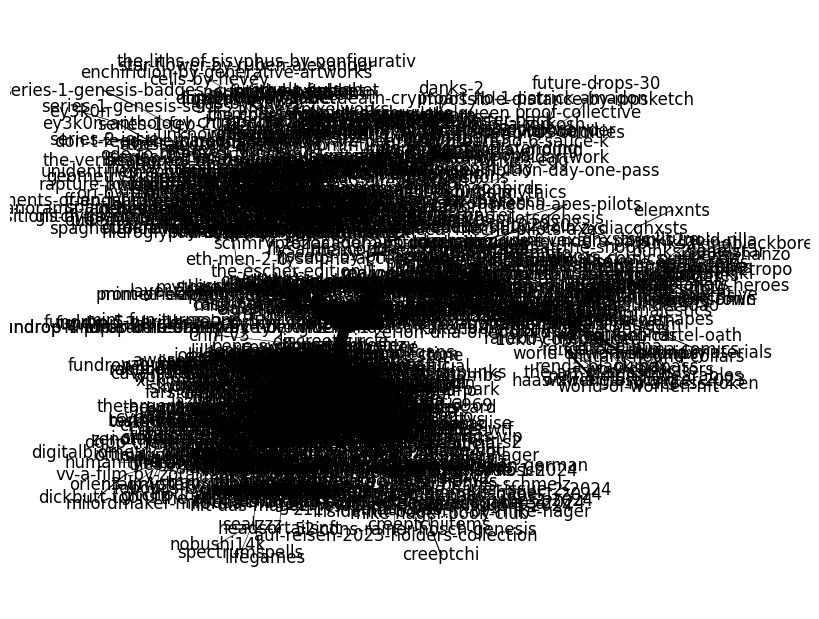

In [68]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
plt.figure(figsize=(8,6))
edges,weights = zip(*nx.get_edge_attributes(G0,'weight').items())
pos =  nx.nx_agraph.graphviz_layout(G0, prog="neato")
# draw graph
nx.draw(
    G0, pos,
    # nodes
    node_size=2, node_color='k', linewidths=0, with_labels = True,# (linewidths of node markers)
    # edges
    edgelist = edges,
    width=weights

)
# print(G0.nodes())
with open('milady_slugs.pkl','wb') as f:
    pickle.dump(G0.nodes(),f)

79
['janklerz', 'neko-maker', 'ascii-milady', 'sproto-demons', 'pixeladymaker-bc', 'remixilated-babies', 'water-mililys', 'drifella', 'radbro-brazil', 'joseangel', 'remilio-babies', 'banners-nft', 'ohiolady-maker', 'radbro-webring-v1', 'angel-banners', 'heisei-milady-maker', 'hurt-hapas', 'conspiracy-lady-maker', 'brg-music-group', 'schizoposters', 'milaidys', 'pepe-maker', 'reservoir-dog', 'cigawrettepacks', 'ghibladymaker', 'goulerbros', 'oekakimaker', 'killady', 'muhlady', 'loveposters', 'remisans-inferno', 'meltydiary', 'miladmaker', 'trumplady-maker', 'matrix-milady', 'milady-2-global-terror', 'interkidz', 'remcotuners', 'remembrance-banners', 'bitladymaker', 'radbro-radcats', 'tuners-remco-gangs', 'reptilianbabies', 'negative-milady', 'slavbro-wee-bring-v2', 'milady', 'radhoe', 'mog-auras', 'radbro-webring', 'roritamakers1e2', 'sonoramaker', 'dadbrosv1', 'tlgame', 'meowlady-maker-2', 'pemuto', 'micent-van-gogh', 'pixeladymaker', 'molady', 'remiliangel', 'shiro-oh-i-see', 'remivis

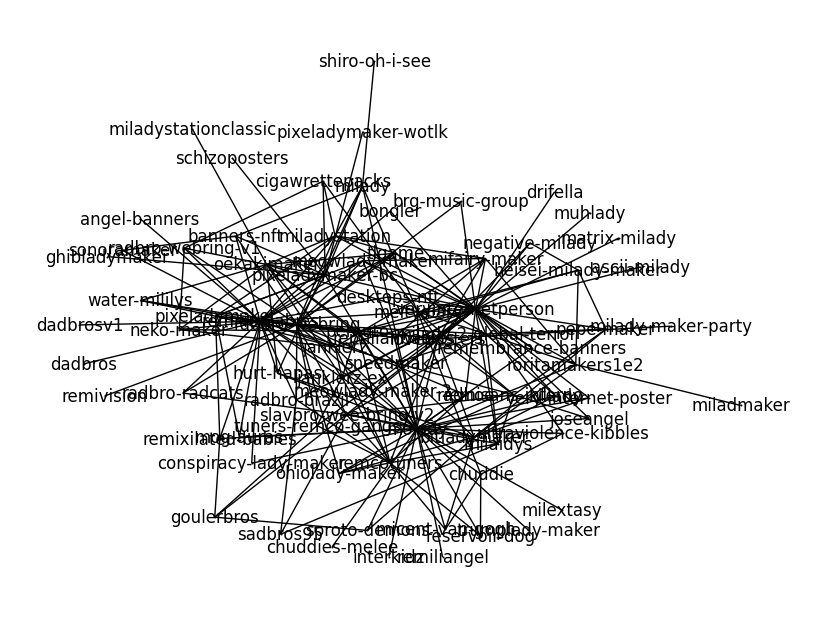

In [43]:
Gcc = nx.node_connected_component(G, 'milady')
print(len(Gcc))
G0 = G.subgraph(Gcc)
print(G0.nodes())
plt.figure(figsize=(8,6))
# edges,weights = zip(*nx.get_edge_attributes(G0,'weight').items())
# print(weights)
pos =  nx.nx_agraph.graphviz_layout(G0, prog="neato")
# draw graph
nx.draw(
    G0, pos,
    # nodes
    node_size=2, node_color='k', linewidths=0, with_labels = True,# (linewidths of node markers)
    # edges
    # edgelist = edges

)

In [69]:
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx
(G)
net.show('test.html')

test.html
